## Librairy import

In [207]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
%matplotlib ipympl
import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
#%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
from tkinter import Tk, filedialog
from tkinter.filedialog import askopenfile
import os

C:/Users/CRose/OneDrive/Documents/School/Cancer Research masters/M2/Physics of LIfe/Practical/My data/05dil2000bin22_1/05dil2000bin22_1_MMStack_processed.tif


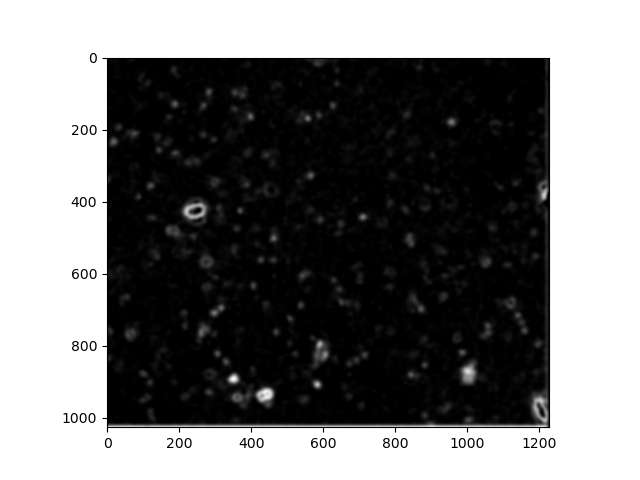

In [209]:
#open dialog box to select the image file to analyze

root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.

root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
file = filedialog.askopenfile(mode='r', filetypes=[('Python Files', '*.tif')])
pathtemp = os.path.abspath(file.name)
# path = filedialog.askdirectory()
path = pathtemp.replace(os.sep, os.altsep)

print(path)

frames = pims.open(path)
#frames = pims.open('075um_crop.tif') # changer le chemin du fichier à ouvrirframes = pims.open('C:/Users/Etudiants/Desktop/tpgang/acquisition 1micro_800dilu.tiff') # changer le chemin du fichier à ouvrir

im=np.float32(np.array(frames))
plt.figure()
plt.imshow(im[0],cmap='gray')

## Particle detection
We're going to use the “trackpy” package to detect the brightest particles in the focal plane of the lens (white particles).
First, we'll detect all intensity fluctuations of a defined size. Then we'll filter them so as to retain only the beads of interest.

The parameters are as follows:
- images of interest (im[??])
- bead diameter (in pixels - odd number)
- invert = True to detect dark and non-light beads

In [212]:
# Define the parameters for detection
img_nb = 9 #number of the frame to test the detection
size_part=15 #size of the particles
detect = False # mode of detection (True for dark particles, False for bright ones)

In [214]:
f = tp.locate(im[img_nb],size_part , invert=detect)
f.head()  # shows the first few rows of data

,y,x,mass,size,ecc,signal,raw_mass,ep
0,6.967828,697.443700,98.660112,4.020890,0.316053,1.719278,531.0,0.141172
1,7.520147,1165.111722,72.209680,3.980033,0.309950,1.322522,263.0,0.318617
2,8.643326,516.270241,120.878475,4.124565,0.176742,1.719278,560.0,0.133148
3,9.771771,1057.933957,452.566894,4.529693,0.043727,4.232069,2278.0,0.030488
4,12.140808,548.229666,756.085602,4.397075,0.073126,8.331886,3513.0,0.019616


Affichage des particules détectées.

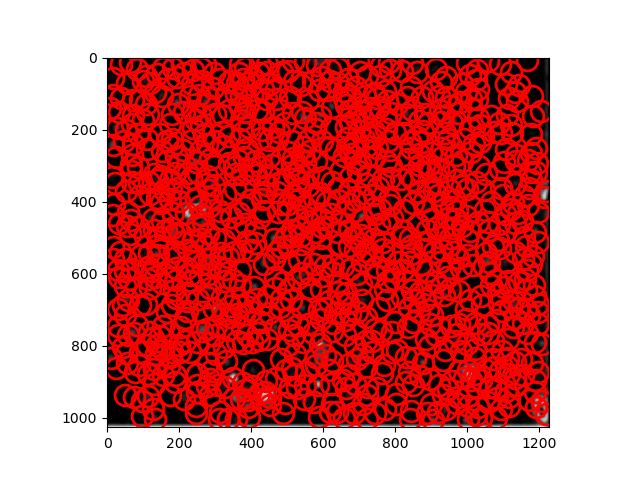

In [216]:
tp.annotate(f, im[img_nb]);

En fonction du résultats, vous pouvez ajuster les paramètres afin d'optimiser la détection des particules qui vous intéressent.
Pour pouvoir faire cela vous pouvez afficher la distribution du nombre de particules en fonction de leur poids (qui correspond à leur brillance, en rouge sur l'illustration).
<div>
<img src="attachment:illu_poids.jpg" width="500"/>
</div>
Vous allez donc devoir sélectionner seulement la population de poids les plus élevés (correspondant aux billes). Vous devrez surement ajuster l'échelle de l'histogramme suivant pour la faire apparaitre).

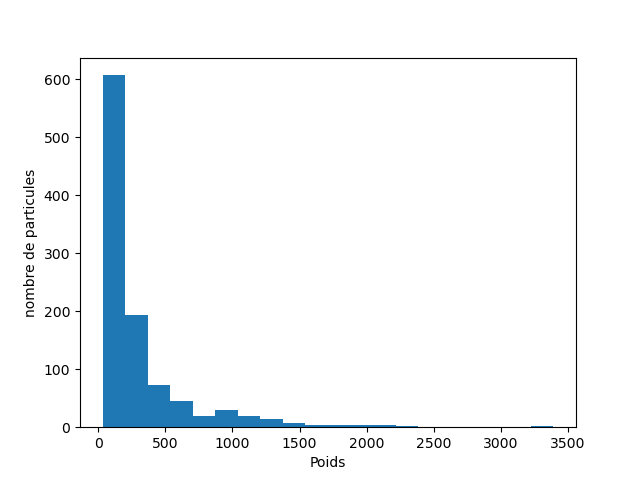

In [218]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='Poids', ylabel='nombre de particules');

Ce graphique vous donne un ordre d'idée des poids des particules et vous permet de fixer un poids seuil en dessous duquel les particules seront exclues.\
Vous pouvez ajuster le poids jusqu'à obtenir une bonne détection de vos particules.\
Rappel: vous cherchez à détecter seulement les particules les plus blanches, celles qui sont bien dans le plan focal de votre objectif, les autres particules risquent de disparaitre au cours du film et donneront seulement des trajectoires courtes.\
\
Vérifier vos résultats en affichant la nouvelle détection ci-dessous.\
\
<span style="color:red"> ***Question :*** *pour quelle.s raison.s les particules peuvent-elles disparaitre?*</span>

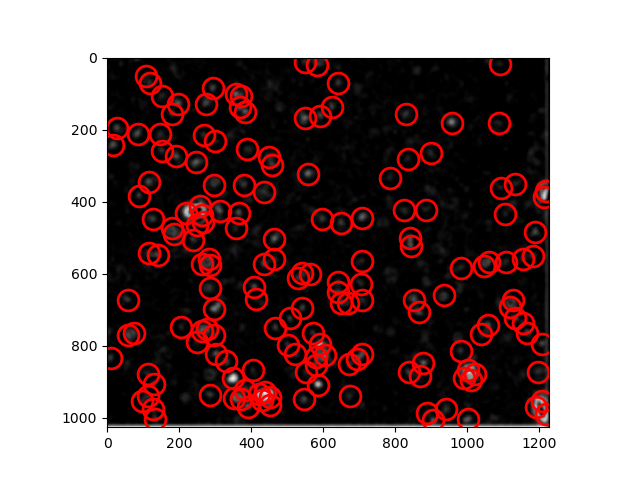

In [220]:
th_mass=0.5e3 # Define the threshold mass for the detection
f = tp.locate(im[img_nb],size_part,invert=detect, minmass=th_mass)
plt.figure()
tp.annotate(f, im[img_nb]);

Détection des particules dans toutes les images du film. Les positions sont stockées dans la variable f.\

In [222]:
f = tp.batch(im[:], size_part, invert=detect, minmass=th_mass);

Frame 119: 173 features


## Génération des trajectoires
Une fois les particules détectées pour chaque image du film, vous devez maintenant reliées entre elles ces particules d'une image à l'autre de manière à obtenir la trajectoire dans le temps de chacune d'entre elles.\
Pour cela, utiliser la fonction link toujours dans le package "trackpy".\
Les paramètres sont les suivants: 
- les positions des particules détectée auparavant, stockées dans "f"
- le rayon (R) du disque dans lequel les particules peuvent se déplacer entre deux images successives. Plus ce rayon est grand plus le temps de calcul est élevé et vous pouvez détecter une autre particule. S'il est trop petit, vous pouvez perdre vos particules au cours du temps.
- memory: le nombre de d'images où on autorise l'algorithme à perdre la particule et la retrouver.
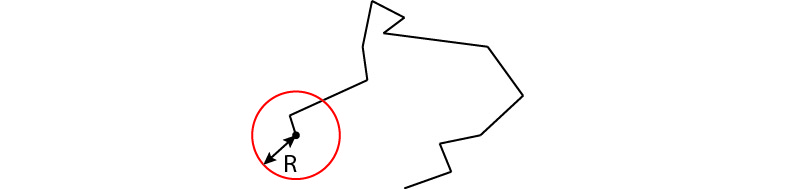

In [223]:
# tp.quiet()  # Turn off progress reports for best performance
R=40
t1 = tp.link(f, R, memory=4)

Frame 119: 173 trajectories present.


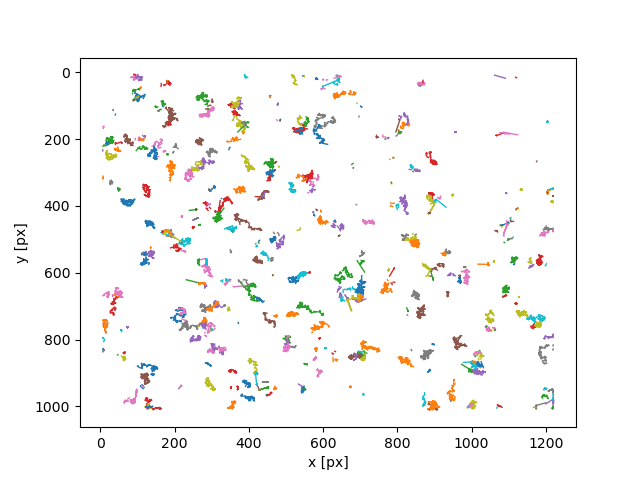

In [224]:
plt.figure()
tp.plot_traj(t1);

Vérifier que les vos trajectoires sont correctes: chaque billes correspond à une ou deux trajectoires (couleur).\
    Ajuster les paramètres en fonction et ré-itérer l'ajustement des paramètres.
    
Cette étape est cruciale pour obtenir des résultats corrects ensuite.

In [225]:
# Filtrage des trajectoires trop courtes:
t2 = tp.filter_stubs(t1, 50)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t1['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 693
After: 159


## Correction des dérives
Si la chambre n'est pas correctement fermée, on peut observer une dérives des particules. Si cette dérive n'est pas trop importante, il est possible de la corriger et d'obtenir tout de même des résultats corrects.

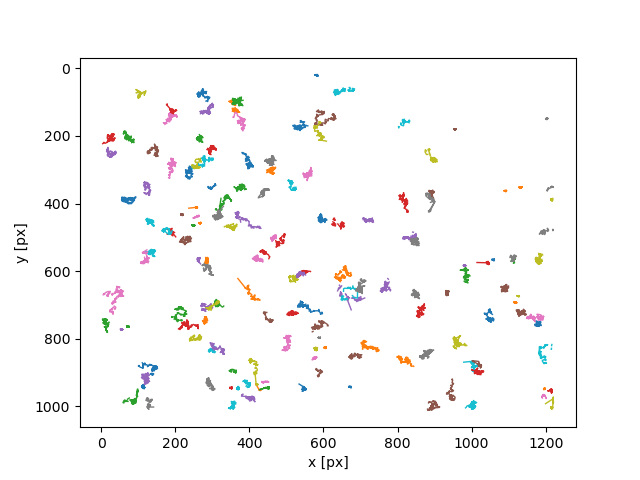

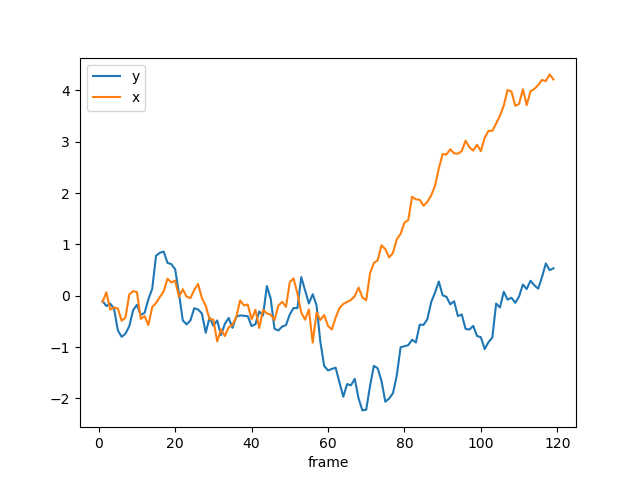

In [226]:
d = tp.compute_drift(t2)
d.plot()

# Correction de la dérive et affichage des trajectoires corrigées.
tm = tp.subtract_drift(t2.copy(), d)
plt.figure()
ax = tp.plot_traj(tm)

### Entrez les paramètres d'acquisition

In [244]:
ima = tp.imsd(tm, 1*3.45/40, 10)  # microns per pixel = binning*3.45/40, frames per second = 10

ValueError: 'particle' is both an index level and a column label, which is ambiguous.

## Display of mean square displacement (MSD)¶

NameError: name 'ima' is not defined

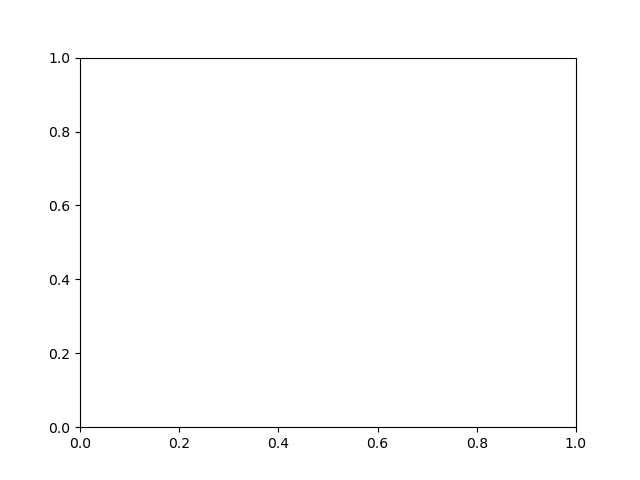

In [241]:
fig, ax = plt.subplots()
ax.plot(ima.index, ima, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In [232]:
em = tp.emsd(tm, 1*3.45/40, 10)  # microns per pixel = binning*330/1040, frames per second = 10

em.head()  # shows the first few rows of data

lagt
0.1    0.097050
0.2    0.150607
0.3    0.205563
0.4    0.251713
0.5    0.300028
Name: msd, dtype: float64

C:\Users\CRose\AppData\Local\Temp\ipykernel_58900\1998257736.py:7: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set(xlim=(0, 20))


[(0.07943282347242814, 20)]

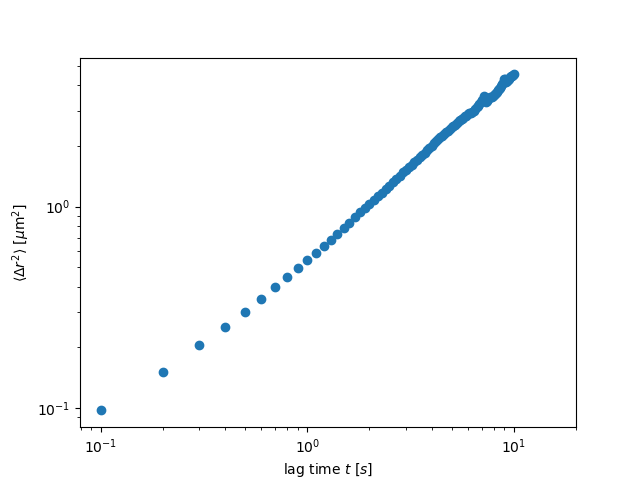

In [234]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$ $[s]$')
ax.set(xlim=(0, 20))


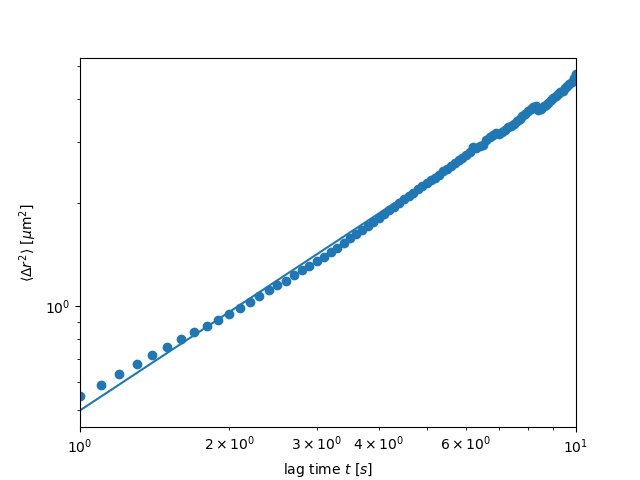

,n,A
msd,0.95103,0.497138


In [29]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$ $[s]$');
tp.utils.fit_powerlaw(em[1:10])  # performs linear best fit in log space, plots

# Analyse des résultats
- Avez-vous un mouvement diffusif pur ? Justifiez
- Si vous avez un mouvement diffusif pur, extrayez D, le coefficient de diffusion.